In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import division
from deltasigma import *

## Multi-bit modulator

/software/anaconda3/envs/deltasigma/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/software/anaconda3/envs/deltasigma/lib/python3.7/site-packages/matplotlib/__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/software/anaconda3/envs/deltasigma/lib/python3.7/site-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
/software/anaconda3/envs/deltasigma/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figu

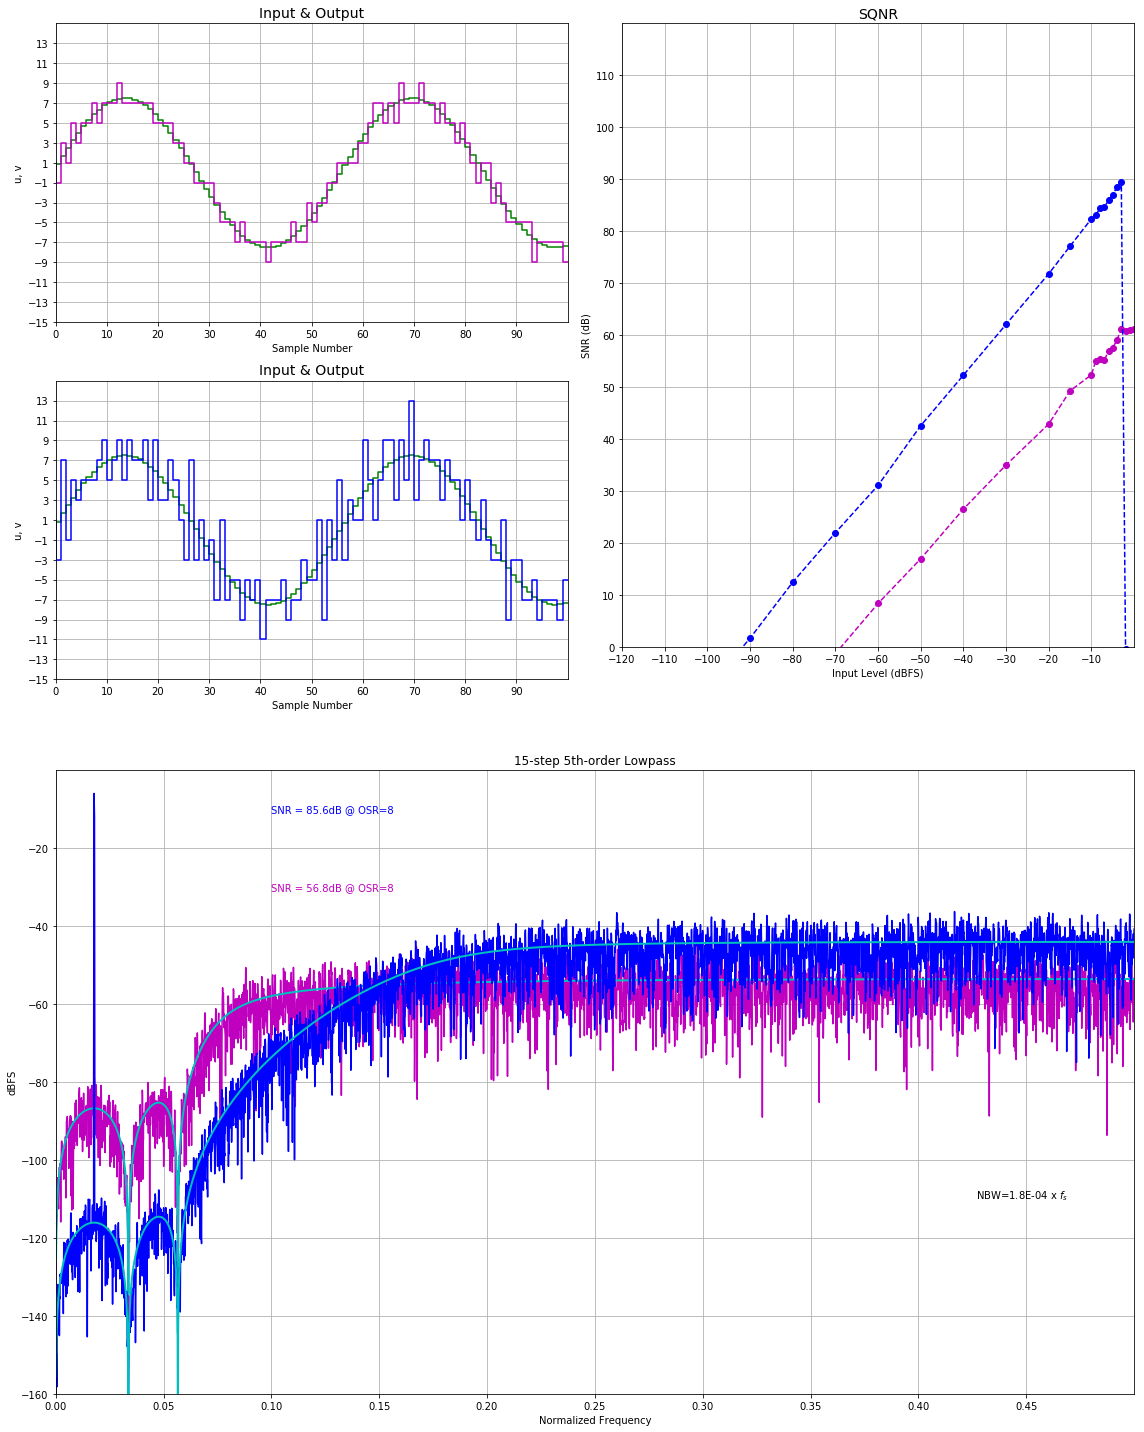

In [3]:
figure(figsize=(16, 20))
colors = ('m', 'b', 'r', 'k')
#Hinf_list = [2, 8] #[2, 8]
Hinf_list = [2, 6] #[2, 8]
f0_list = [0.0, 1./8]
f0 = 0.0
Hinf = 12
i = -1
for col, Hinf in zip(colors, Hinf_list):
#for col, f0 in zip(colors, f0_list):
    i += 2
    OSR = 8 #8
    M = 15 #15 #16
    ORD = 5 #4
    #f0 = 1./8 #0.0
    
    H = synthesizeNTF(ORD, OSR, 1, Hinf, f0)
    #H = synthesizeChebyshevNTF(ORD, OSR, 1, Hinf)
    #H = clans(ORD,OSR,5,rmax=0.95,opt=1)
    N = 8192
    fB = int(np.ceil(N/(2.*OSR)))
    ftest = int(np.floor(2./7*fB))
    u = 0.5*M*np.sin(2*np.pi*ftest/N*np.arange(N))
    v, xn, xmax, y = simulateDSM(u, H, M + 1)
    
    subplot(int('42' + str(i)))
    t = np.arange(101)
    #t = np.arange(1001)
    step(t, u[t], 'g')
    hold(True)
    step(t, v[t], col)
    figureMagic([0, 100], 10, None, [-M, M], 2, None, None,'Input & Output')
    #figureMagic([0, 1000], 10, None, [-M, M], 2, None, None,'Input & Output')
    xlabel('Sample Number')
    ylabel('u, v')
    
    subplot(222)
    snr, amp = simulateSNR(H, OSR, None, 0., M + 1)
    plot(amp, snr,'o' + col, amp, snr, '--' + col)
    hold(True)
    figureMagic([-120, 0], 10, None, [0, 120], 10, None, None,'SQNR')
    xlabel('Input Level (dBFS)')
    ylabel('SNR (dB)')
    #pk_snr, pk_amp = peakSNR(snr, amp)
    #text(-13, pk_snr, 'peak SNR = %4.1fdB\n@ OSR = %d\n' % (pk_snr, OSR), horizontalalignment='right', color=col)
    
    subplot(212)
    f = np.linspace(0, 0.5, int(N/2.) + 1)
    spec = np.fft.fft(v*ds_hann(N))/(M*N/4)
    plot(f, dbv(spec[:int(N/2) + 1]), col)
    snr = calculateSNR(spec[2:fB + 1], ftest - 2)
    text(0.1, 10*(i - 4), 'SNR = %4.1fdB @ OSR=%d' % (snr, OSR), verticalalignment='center', color=col)
    figureMagic([0, 0.5], 0.05, None, [-160, 0], 20, None, None,'Output Spectrum')
    xlabel('Normalized Frequency')
    ylabel('dBFS')
    
    NBW = 1.5/N
    Sqq = 4*evalTF(H, np.exp(2j*np.pi*f))**2/(3.*M**2)
    hold(True)
    plot(f, dbp(Sqq*NBW), 'c', linewidth=2)
    if i == 1:
        text(0.47, -110, 'NBW=%4.1E x $f_s$ '% NBW, horizontalalignment='right')
title('15-step 5th-order Lowpass')
tight_layout()

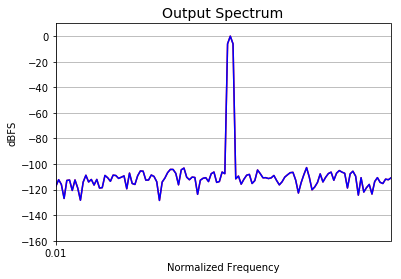

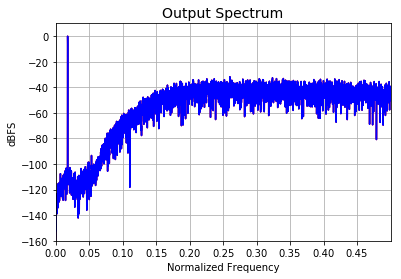

In [4]:
opt_p7 = {15: [3, 1, 3, 1, 3, 1, 3], 
          13: [3, 1, 1, 3, 1, 1, 3], 
          11: [3, -1, 3, 1, 3, -1, 3], 
           9: [1, 3, 1, -1, 1, 3, 1], 
           7: [1, 1, 3, -3, 3, 1, 1], 
           5: [1, 1, -1, 3, -1, 1, 1], 
           3: [1, -1, 3, -3, 3, -1, 1], 
           1: [-1, 3, -1, -1, -1, 3, -1]}

opt_p9 = {15: [1, 1, 1, 3, 3, 3, 1, 1, 1], 
          13: [-1, 3, 3, 3, -3, 3, 3, 3, -1], 
          11: [-1, 3, 3, -1, 3, -1, 3, 3, -1], 
           9: [-1, 3, 1, 3, -3, 3, 1, 3, -1], 
           7: [-1, 3, 1, -1, 3, -1, 1, 3, -1], 
           5: [-1, 3, -1, 3, -3, 3, -1, 3, -1], 
           3: [-1, 3, -1, -1, 3, -1, -1, 3, -1], 
           1: [-1, 3, -3, 3, -3, 3, -3, 3, -1]}

modseq = opt_p7
#modseq = opt_p9

lms = len(modseq[15])
vmod = np.zeros(lms * len(v) )
for i in range(len(v)):
    val = v[i]
    s = 1
    if val<0:
        val = -val
        s = -1
    vmod[i*lms:(i+1)*lms] = s * np.array( modseq[val] )

f = np.linspace(0, 0.5, int(N*lms/2.) + 1)
spec = np.fft.fft(vmod*ds_hann(N*lms))/(M*N*lms/4)
spec = spec/np.max(abs(spec))
plot(f*lms, dbv(spec[:int(N*lms/2) + 1]), 'r')

f2 = np.linspace(0, 0.5, int(N/2.) + 1)
spec2 = np.fft.fft(v*ds_hann(N))/(M*N/4)
spec2 = spec/np.max(abs(spec))
plot(f2, dbv(spec2[:int(N/2) + 1]), 'b')

fmin = 0.01
fmax = 0.025
#fmin = 0.0
#fmax = 0.5
figureMagic([fmin, fmax], 0.05, None, [-160, 10], 20, None, None,'Output Spectrum')
xlabel('Normalized Frequency')
ylabel('dBFS')
show()

plot(f*lms, dbv(spec[:int(N*lms/2) + 1]), 'r')
plot(f2, dbv(spec2[:int(N/2) + 1]), 'b')
fmin = 0.0
fmax = 0.5
figureMagic([fmin, fmax], 0.05, None, [-160, 10], 20, None, None,'Output Spectrum')
xlabel('Normalized Frequency')
ylabel('dBFS')
show()

### System version information

In [5]:
#%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%reload_ext version_information

%version_information numpy, scipy, matplotlib, deltasigma

Software versions
Python 3.7.11 64bit [GCC 7.5.0]
IPython 7.29.0
OS Linux 4.15.0 188 generic x86_64 with debian buster sid
numpy 1.21.2
scipy 1.7.1
matplotlib 2.2.3
deltasigma 0.2.2
Sun Jul 03 12:33:17 2022 CEST